# A thalamo-cortical model of post-sleep memory improvement

*Bruna, Catalina and Flávio.*

LASCON 2024

In this Jupyter Notebook, we are going to model a thalamo-cortical model of post-sleep memory improvement. This project reproducts the paper ["Sleep-like slow oscillations improve visual classification through synaptic homeostasis and memory association in a thalamo-cortical model"](https://www.nature.com/articles/s41598-019-45525-0), whose code is not publicly available. The project is also part of the activities developed during LASCON 2024. 

In this notebook, we will go step by step in the simulation of the phases:

1. Get MNIST dataset
2. Training phase
3. Pre-sleep retrieval phase
4. Sleep phase
5. Post-sleep retrieval phase

You can find model creatin details in network.py file.

Let's start. :)

-------------------------------

Importing libraries

In [1]:
import nest
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model.network import Network
from dataset.dataclass import MNIST


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Jul 22 2023 00:00:00

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## 1. Get MNIST dataset

To save up time, we are using downloade data generated from the dataclass.py file. If you want to generate in this notebook, do the following:

- Process data: Ex.: x_train_feat_vector = data.process_and_store(data.x_train)

This might take up 5 minutes. 

In [2]:
# Instantiate constructor
data = MNIST()

From the MNIST dataset, let's now get three times the number 0, 1, and 2, totaling nine images

In [3]:
# Find indices of the n first occurrences of 0, 1, and 2
n_first_occurr = 3

zero_indices = np.where(data.y_train == 0)[0][:n_first_occurr]
one_indices = np.where(data.y_train == 1)[0][:n_first_occurr]
two_indices = np.where(data.y_train == 2)[0][:n_first_occurr]

print("First three 0 occurrences:", zero_indices)
print("First three 1 occurrences:", one_indices)
print("First three 2 occurrences:", two_indices)

First three 0 occurrences: [ 1 21 34]
First three 1 occurrences: [3 6 8]
First three 2 occurrences: [ 5 16 25]


Then, we have our total n of training images = 9.

Let's generate the list we are going to input to the tc population.

In [4]:
# Combine the indices for 0, 1, and 2
all_indices = [zero_indices, one_indices, two_indices]

# Flatten the list of numpy arrays indices
flat_indices = [item for sublist in all_indices for item in sublist]

# Create an empty list to store the result
train_feat_vect = []

# Transform data feature vector into list
x_train_feat_vectors = data.x_train_feat_vect.tolist()

# Loop through each set of indices and append corresponding feature vectors
for index in flat_indices:
    feat_vector = x_train_feat_vectors[index]
    train_feat_vect.append(feat_vector)

In [5]:
# Generate random feature vectors
vector_length = 324
non_zero_elements = 81
binary_vectors = [0] * (9)

for i in range(9):
    binary_vectors[i] = [0] * vector_length
    positions_to_set = random.sample(range(vector_length), non_zero_elements)
    for position in positions_to_set:
        binary_vectors[i][position] = 1   

print("Binary Vector:", binary_vectors)


Binary Vector: [[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 

## 2. Training phase

*"Every time a new training image is presented to the network through the thalamic pathway, the facilitation signal coming from the contextual signal provides a 2 kHz Poisson spike train to a different set of 20 neurons, inducing the group to encode for that specific input stimulus (see the Discussion section for details about this choice). Additionally a 10 kHz Poisson spike train is provided to inhibitory neurons (in) to prevent already trained neurons to respond to new stimuli in the training phase."* (Capone, C., Pastorelli, E., Golosio, B. et al. 2019)

First, let's instantiate the network and connect it to the multimeters and spike recorders.

In [6]:
# Instantiate network
net = Network(n_train_images=9)

In [7]:
# Connect to multimeters and spike records
net.connect_all_devices()

Run simulation.

In [8]:
# The inhibitory signal in commented, even though it should be present, to reproduce the first figure of the paper. 
"""
for i in range(0, net.n_train_images):
    if i == 0:
        net.input_train_signal(time_id=i, feature_vector=binary_vectors[i])
        net.input_context_signal(neuron_group=i)
        print(f"Run {i}.")
        nest.Simulate(900.0)
    else:
        net.input_train_signal(time_id=i, feature_vector=binary_vectors[i])
        net.input_context_signal(neuron_group=i)
        #net.input_inhib_signal(time_id=i)
        print(f"Run {i}.")
        nest.Simulate(900.0)"""

'\nfor i in range(0, net.n_train_images):\n    if i == 0:\n        net.input_train_signal(time_id=i, feature_vector=binary_vectors[i])\n        net.input_context_signal(neuron_group=i)\n        print(f"Run {i}.")\n        nest.Simulate(900.0)\n    else:\n        net.input_train_signal(time_id=i, feature_vector=binary_vectors[i])\n        net.input_context_signal(neuron_group=i)\n        #net.input_inhib_signal(time_id=i)\n        print(f"Run {i}.")\n        nest.Simulate(900.0)'

In [9]:
i=0
feat_vect = train_feat_vect[i]
net.input_train_signal(time_id=i, feature_vector=feat_vect)
net.input_context_signal(neuron_group=i)
nest.Simulate(800.0)

Training signal successfully created.
Connecting input to the tc population...
... training signal successfully connected to the tc population.
Contextual signal successfully created.
Connecting input to the cx population...
... contextual signal successfully connected to the cx population.
Inhibitory signal successfully created.
Connecting input to the in population...
... inhibitory signal successfully connected to the in population.

Jan 31 12:27:21 NodeManager::prepare_nodes [Info]: 
    Preparing 915 nodes for simulation.

Jan 31 12:27:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 915
    Simulation time (ms): 800
    Number of OpenMP threads: 1
    Not using MPI

Jan 31 12:27:33 SimulationManager::run [Info]: 
    Simulation finished.


Plot results.

Cx population:

ValueError: max() iterable argument is empty

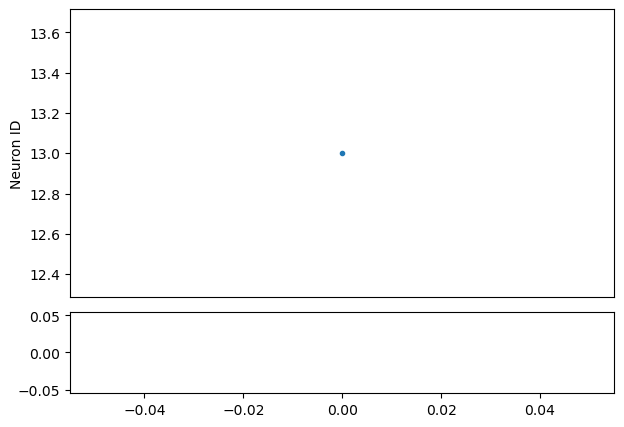

In [10]:
nest.raster_plot.from_device(net.spikes_cx, hist=True)

Tc population:

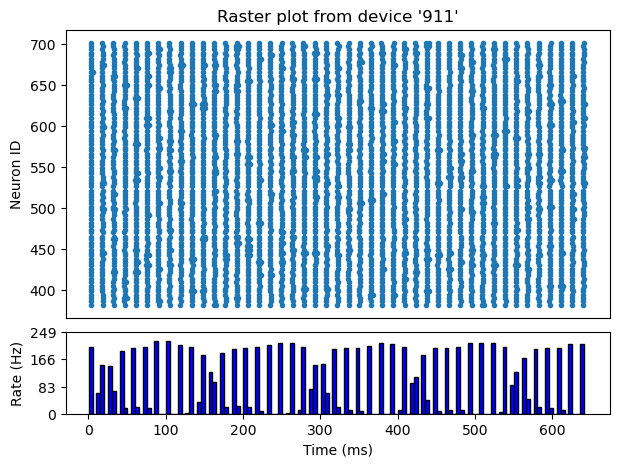

In [11]:
nest.raster_plot.from_device(net.spikes_tc, hist=True)

In [13]:
# Get events from multimeter
tc_vm = net.mult_tc.get()
vm_tc = tc_vm["events"]["V_m"]
ts_vm_tc = tc_vm["events"]["times"]

# Get events from spike recorder
tc_spike = net.spikes_tc.get("events")
send_tc = tc_spike["senders"]
ts_spike_tc = tc_spike["times"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


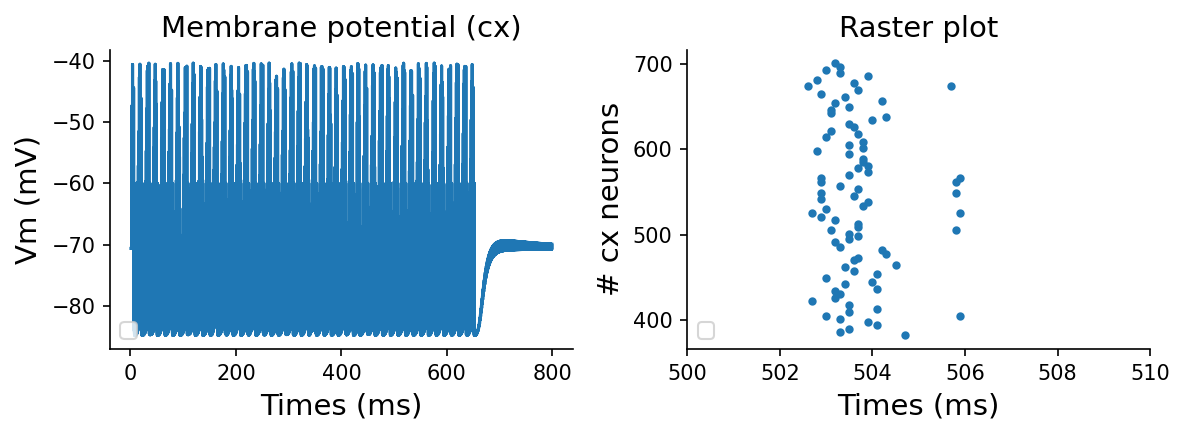

In [15]:
# Plot results

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(8, 3), sharey=False)

axs[0].plot(ts_vm_tc, vm_tc)
axs[0].set_title('Membrane potential (cx)', size=14)
axs[0].legend(loc=3)
axs[0].set_xlabel("Times (ms)", size=14)
axs[0].set_ylabel("Vm (mV)", size=14)  # Fixed the ylabel, and "mV" is commonly used for millivolts

axs[1].plot(ts_spike_tc, send_tc, '.')
axs[1].set_title('Raster plot', size=14)
axs[1].legend(loc=3)
axs[1].set_xlabel("Times (ms)", size=14)
axs[1].set_xlim([500, 510])
axs[1].set_ylabel("# cx neurons", size=14)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
sns.despine()
plt.show()

In population:

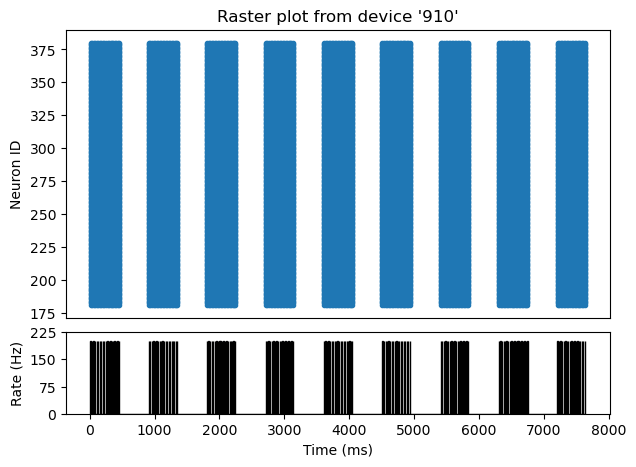

In [10]:
nest.raster_plot.from_device(net.spikes_in, hist=True)

Re population:

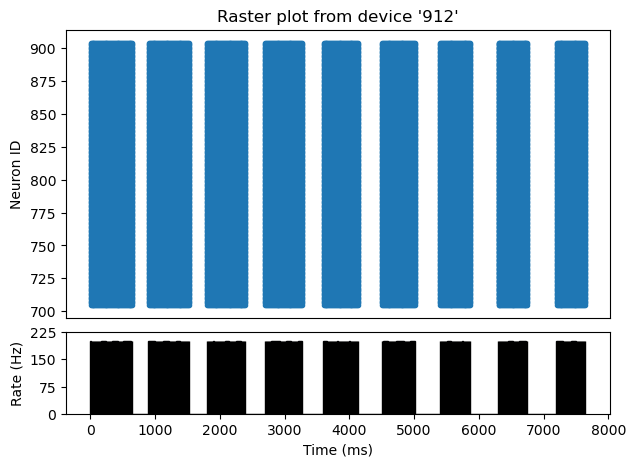

In [11]:
nest.raster_plot.from_device(net.spikes_re, hist=True)

## 3. Pre-sleep retrieval phase

*"During the retrieval phase only the 30 kHz input to thalamic cell is provided, while the contextual signal is off."* (Capone, C., Pastorelli, E., Golosio, B. et al. 2019)

Run simulation.

In [12]:
# Simulate for all populations
i_retrieve = net.n_train_images + 1

for i in range(0 + i_retrieve, i_retrieve + net.n_train_images):
    net.input_train_signal(time_id=i, feature_vector=train_feat_vect[10-i])
    print(f"Run {i}.")
    nest.Simulate(900.0)

Training signal successfully created.
Connecting input to the tc population...
... training signal successfully connected to the tc population.
Run 10.

Jan 31 11:06:52 NodeManager::prepare_nodes [Info]: 
    Preparing 931 nodes for simulation.

Jan 31 11:06:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 931
    Simulation time (ms): 900
    Number of OpenMP threads: 1
    Not using MPI

Jan 31 11:06:59 SimulationManager::run [Info]: 
    Simulation finished.
Training signal successfully created.
Connecting input to the tc population...
... training signal successfully connected to the tc population.
Run 11.

Jan 31 11:06:59 NodeManager::prepare_nodes [Info]: 
    Preparing 932 nodes for simulation.

Jan 31 11:06:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 932
    Simulation time (ms): 900
    Number of OpenMP threads: 1
    Not using MPI

Jan 31 11:07:12 SimulationManager::run [Info]: 
    Simulation finished.
Training signal su

Plot results.

Cx population:

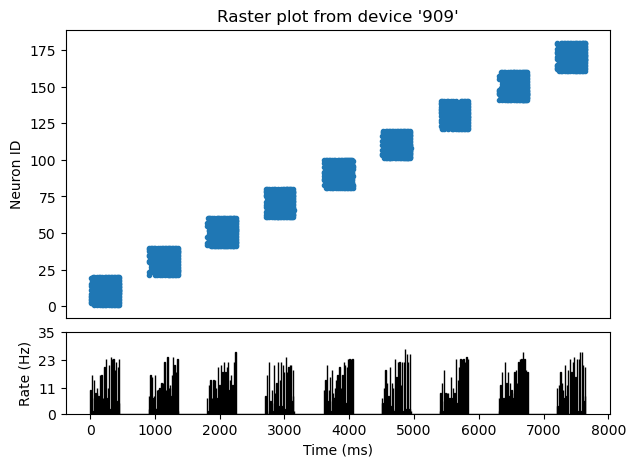

In [13]:
nest.raster_plot.from_device(net.spikes_cx, hist=True)

Tc population:

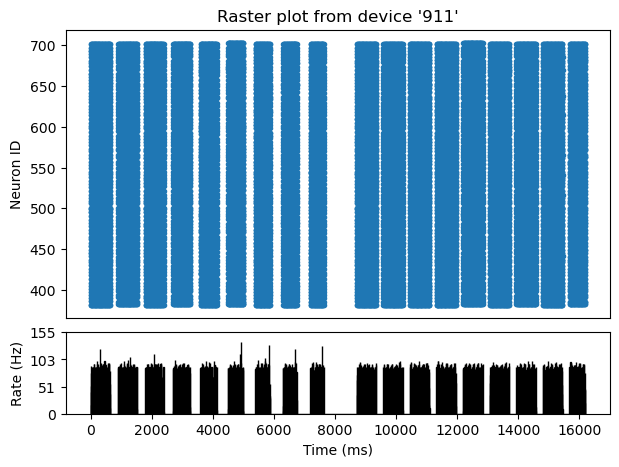

In [14]:
nest.raster_plot.from_device(net.spikes_tc, hist=True)

In population:

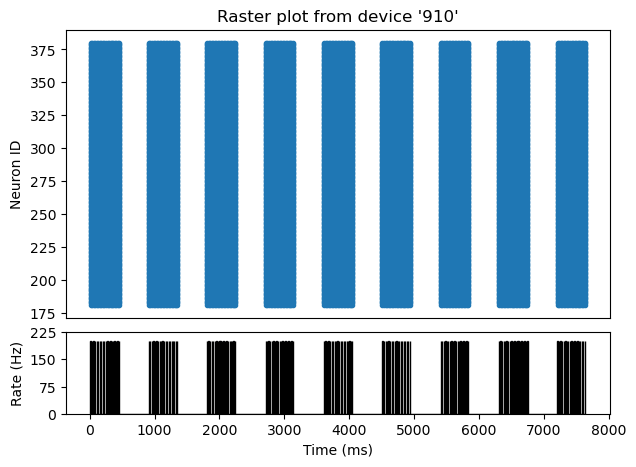

In [15]:
nest.raster_plot.from_device(net.spikes_in, hist=True)

Re population:

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fcbb116c860>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
                                                       ^^^^^^
KeyboardInterrupt: 


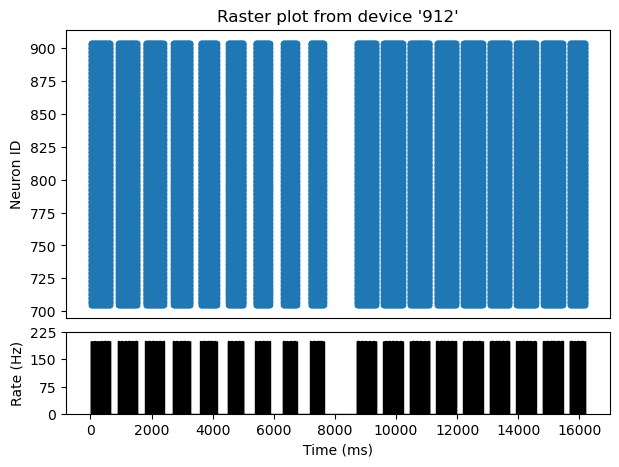

In [16]:
nest.raster_plot.from_device(net.spikes_re, hist=True)

## 4. Sleep phase

*"After the training stage, the sleep-like thalamo-cortical spontaneous slow oscillations activity is induced for a total duration of 600s by providing a non-specific Poisson noise inside the cortex (700 Hz) and increasing the strength of SFA parameter (b = 60, in eq. (1)). No external stimulus is provided to cells. Also, the synaptic weights between inhibitory and excitatory neurons in the cortex is reduced to -0.5. In this stage asymmetric STDP plasticity (alpha = 3.0) is active in the recurrent cx connectivity, inducing sleep-induced modification in the synaptic weights structure. The parameters’ change to obtain the slow oscillating regime were chosen relying on mean field theory framework18,19."* (Capone, C., Pastorelli, E., Golosio, B. et al. 2019)

Simulate sleep.

In [ ]:
# Input sleep oscillation
net.input_sleep()

Generating sleep oscillations...
...done.
Connecting input to the cortex populations...
... sleep oscillation signal successfully inputed to the cx and in populations (i.e., whole cortex).

Jan 30 19:05:24 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.


In [ ]:
# Run simulation
nest.Simulate(5000.0)


Jan 30 19:05:24 NodeManager::prepare_nodes [Info]: 
    Preparing 940 nodes for simulation.

Jan 30 19:05:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 940
    Simulation time (ms): 5000
    Number of OpenMP threads: 1
    Not using MPI

Jan 30 19:05:54 SimulationManager::run [Info]: 
    Simulation finished.


Get results.

Cx population:

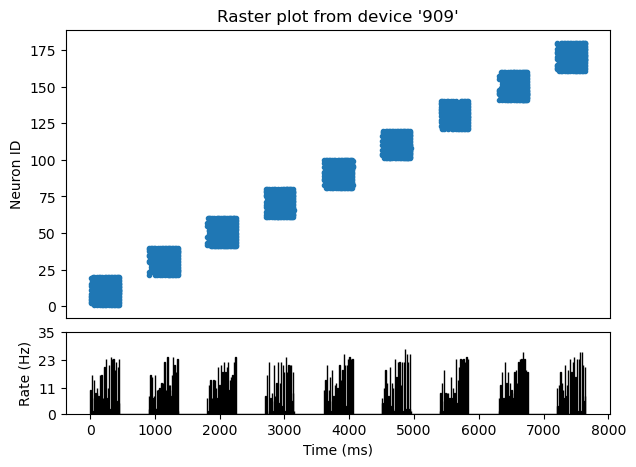

In [ ]:
nest.raster_plot.from_device(net.spikes_cx, hist=True)

Tc population:

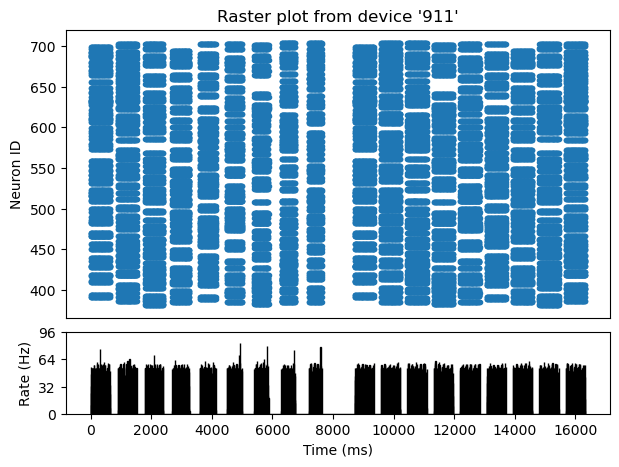

In [ ]:
nest.raster_plot.from_device(net.spikes_tc, hist=True)

In population:

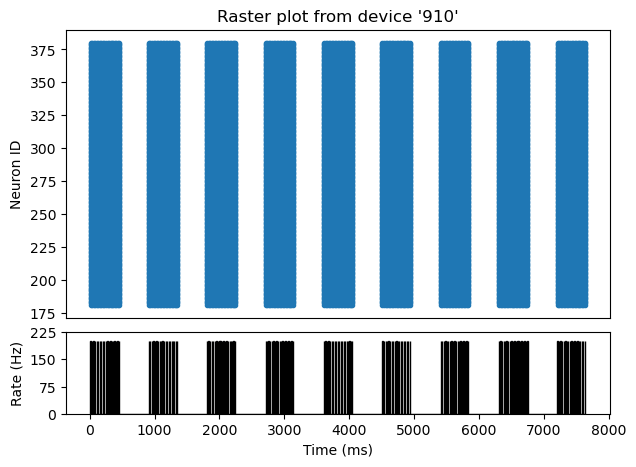

In [ ]:
nest.raster_plot.from_device(net.spikes_in, hist=True)

Re population:

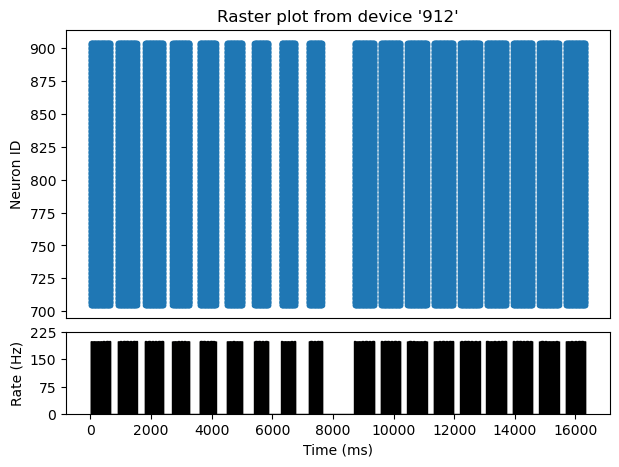

In [ ]:
nest.raster_plot.from_device(net.spikes_re, hist=True)